### Testing Matlab function from Python 

In [1]:
from ansys.mapdl.core import launch_mapdl

import matplotlib.pyplot as plt
import numpy as np
mapdl = launch_mapdl(nproc=4)

In [41]:
mapdl.prep7()
mapdl.units("SI")  # SI - International system (m, kg, s, K).


# Create Node
mapdl.n(1,"0","0","0")
mapdl.n(2,"0","0","10")
mapdl.n(3,"10","0","10")
mapdl.n(4,"0","10","10")

# Define mass21 element 
mapdl.et(1, "MASS21", kop3=0)
mapdl.type(1)
mapdl.real(1)
mapdl.r(1,100,300,200)
mapdl.e(2)

mapdl.et(2, "COMBIN14", kop2=3)
mapdl.type(2)
mapdl.real(2)
k = (4*np.pi**2)*20000
mapdl.r(2,k,1000)
mapdl.e(1,2)

mapdl.et(3, "COMBIN14", kop2=1)
mapdl.type(3)
mapdl.real(3)
k = (4*np.pi**2)*10000
mapdl.r(3,k,1000)
mapdl.e(3,2)

mapdl.et(4, "COMBIN14", kop2=2)
mapdl.type(4)
mapdl.real(4)
k = (4*np.pi**2)*30000
mapdl.r(4,k,1000)
mapdl.e(4,2)


mapdl.nsel("ALL")
mapdl.allsel()
mapdl.nummrg("ALL")

freq = np.array([0,100])
U_input = np.array([1,1])
U_signal = np.column_stack((freq, U_input))
mapdl.load_table("TF_input", U_signal ,"FREQ")

#mapdl.eplot(
#   vtk=True,
#   show_node_numbering=True,
#   cpos="yz",
#   show_edges=True,
#   show_axes=True,
#   line_width=2)


In [42]:
mapdl.run("/SOLU")
mapdl.antype(3)  

mapdl.outres("ALL","ALL")	
mapdl.outres("NSOL","1")
#mapdl.outres("EPFL")
#mapdl.outres("ESOL")
#mapdl.outres("RSOL")
#mapdl.outres("V","1")
#mapdl.outres("A","1")

mapdl.harfrq("0.1","100")

substep = int(100/0.2)
min_sub = int(100/0.1)
max_sub = int(100/0.5)
mapdl.nsubst(substep,min_sub,max_sub)


#mapdl.eqslv("SPARSE")  # use sparse solver
mapdl.dmprat("0.05")
#mapdl.hrout(reimky = "ON")
#mapdl.d("1","ACCZ","%ACC_input%")
mapdl.d("1","UZ","%TF_input%")
mapdl.d("3","UX","%TF_input%")
mapdl.d("4","UY","%TF_input%")

mapdl.solve()

*****  ANSYS SOLVE    COMMAND  *****



   D I S T R I B U T E D   D O M A I N   D E C O M P O S E R

 ...Number of frequency solutions:  500
 ...Decompose to 4 frequency domains (with 1 processes per domain)


 *** NOTE ***                            CP =       4.234   TIME= 01:45:51
 There is no title defined for this analysis.                            

 *** WARNING ***                         CP =       4.234   TIME= 01:45:51
 Real constant 3 referenced by at least element types 2 and 3, both of   
 which are (COMBIN14) elements.                                          

 *** WARNING ***                         CP =       4.234   TIME= 01:45:51
 Real constant 4 referenced by at least element types 2 and 4, both of   
 which are (COMBIN14) elements.                                          

 *** WARNING ***                         CP =       4.234   TIME= 01:45:51
 Nodes I and J of element 2 ( COMBIN14 ) are not coincident.             

 *** WARNING ***                         

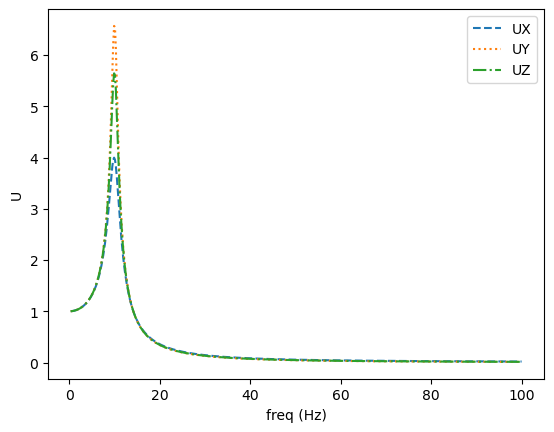

In [43]:
mapdl.post26()

#acc_z_EG = mapdl.nsol("2","1","U","Z")
acc_x_1F = mapdl.nsol("3","2","U","X")
acc_y_1F = mapdl.nsol("4","2","U","Y")
acc_z_1F = mapdl.nsol("5","2","U","Z")

freq_values = mapdl.post_processing.frequency_values
freq_values = np.unique(freq_values)
U_info_EG = np.empty((0, 3))
U_info_1F = np.empty((0, 3))

U_EG = []
U_1F = []
U_X = []
U_Y = []
U_Z = []
for f in freq_values:
    #print(mapdl.get("U_EG","VARI","2","AMPL",f))
    #print(mapdl.get("U_1F","VARI","3","AMPL",f))
    #U_EG_real = mapdl.get("U_EG","VARI","2","REAL",f)
    #U_EG_imag = mapdl.get("U_EG","VARI","2","IMAG",f)
    #U_1F_real = mapdl.get("U_1F","VARI","3","REAL",f)
    #U_1F_imag = mapdl.get("U_1F","VARI","3","IMAG",f)

    #U_info_EG = np.vstack((U_info_EG, np.array([f, U_EG_real , U_EG_imag])))
    #U_info_1F = np.vstack((U_info_1F, np.array([f, U_1F_real , U_1F_imag])))
    
    #U_EG.append(mapdl.get("U_EG","VARI","2","AMPL",f))
    #U_1F.append(mapdl.get("U_1F","VARI","3","AMPL",f))
    U_X.append(mapdl.get("U_EG","VARI","3","AMPL",f))
    U_Y.append(mapdl.get("U_EG","VARI","4","AMPL",f))
    U_Z.append(mapdl.get("U_EG","VARI","5","AMPL",f))

plt.plot(freq_values, U_X, label="UX",linestyle="--")
plt.plot(freq_values, U_Y, label="UY",linestyle=":")
plt.plot(freq_values, U_Z, label="UZ",linestyle="-.")
#plt.plot(freq_values, U_1F, label="ACC 1F")
#plt.plot(time_values, label="ACC time")
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("U")
plt.show()



In [7]:

import matlab.engine
import numpy as np
import matplotlib.pyplot as plt


# Start the matlab engine
eng = matlab.engine.start_matlab()
# Link to the dir of matlab function
eng.cd(r'C:\Users\v196m\Desktop\master_project\Masterarbeit\GroundMotion\GroundMotionGeneration', nargout=0)
#s = eng.genpath('\BaselineCorrection')
#eng.addpath(s, nargout=0)
#eng.cd(r'C:\Users\v196m\Desktop\master_project\Masterarbeit\GroundMotion\GroundMotionGeneration\BaselineCorrection', nargout=0)
# Parameter of GM setting
Start_Time = 0.005
End_time = 15.005
Time_interval = 0.005
Time =  np.arange(Start_Time, End_time, Time_interval)

Time_info = np.array([0.5,	4.51602635361311,	6.51382766164269,	10.8203132545630])
FRF_info  = np.array([85.634147247517, 0.364521248606246, 0.213591303771144])
AriasIntensity = 0.0000508679639647511

# Generate ground motion
time,acc,vel,disp = eng.fns_generateGM_Params(5,Time,100,"Hu_S0", FRF_info, Time_info, AriasIntensity,1, nargout=4)
acc_signal = np.column_stack((time, acc))
vel_signal = np.column_stack((time, vel))

time_interval_transient = 0.005
n_time=int(((End_time-Start_Time)/time_interval_transient)+1)
eng.quit()


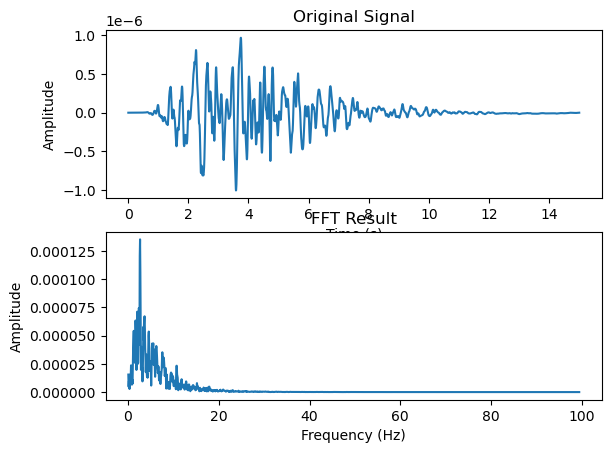

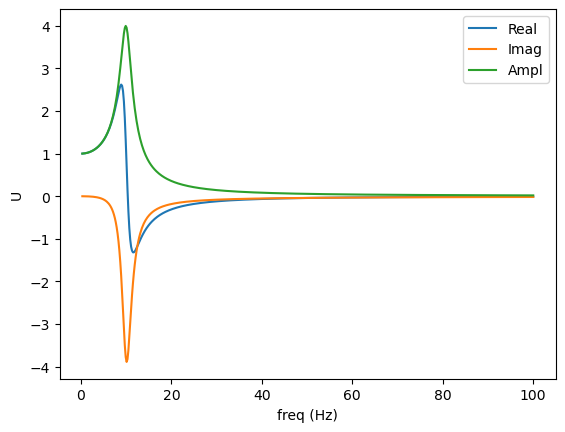

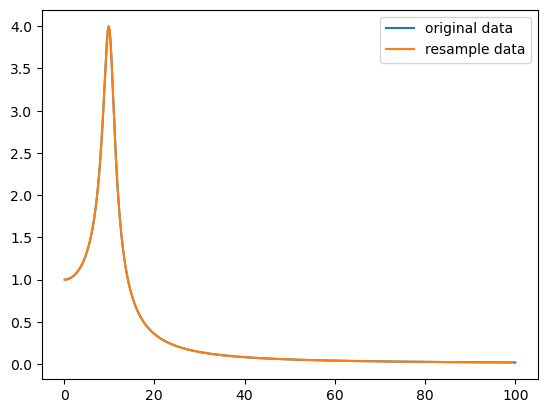

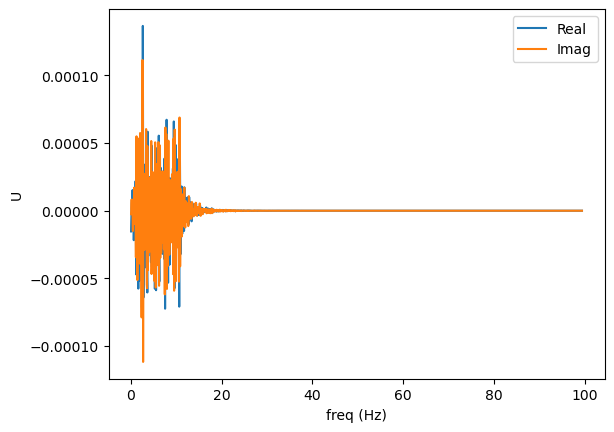

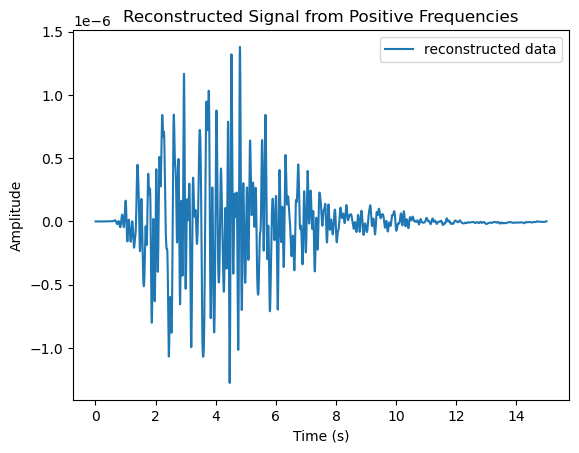

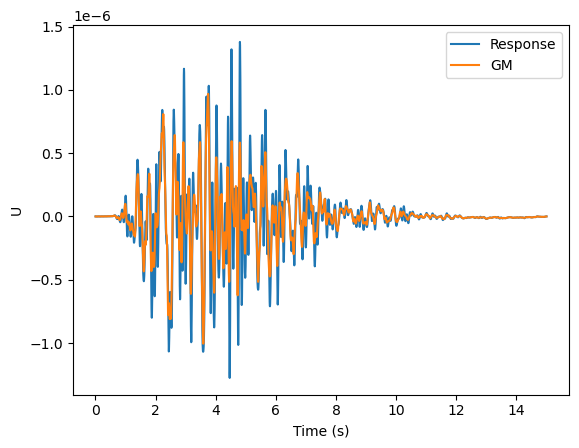

In [13]:
import HalfPositive_FFT_IFFT as HPFFT


time = np.array(time)
ampl = np.array(disp)
freq,cmplx_values = HPFFT.FFT_half_positive(time,np.squeeze(disp),False,True)

FRF_freq = U_info_1F[:,0][::2]
FRF_real = U_info_1F[:,1][::2]
FRF_imag = U_info_1F[:,2][::2]
FRF_response = FRF_real + 1j * FRF_imag

plt.plot(FRF_freq,FRF_real, label="Real")
plt.plot(FRF_freq, FRF_imag, label="Imag")
plt.plot(FRF_freq,np.abs(FRF_response), label="Ampl")
#plt.plot(time_values, label="ACC time")
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("U")
plt.show()


FRF_freq_resample, FRF_values_resample = HPFFT.signal_resample_inter1(FRF_freq,FRF_response, resamples_type = 'array', resample_list = freq, resample_check = True)
Response = FRF_values_resample*cmplx_values

plt.plot(freq,np.real(Response), label="Real")
plt.plot(freq, np.imag(Response), label="Imag")
#plt.plot(FRF_freq,np.abs(FRF_response), label="Ampl")
#plt.plot(time_values, label="ACC time")
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("U")
plt.show()

time_res, ampl_res = HPFFT.IFFT_half_positive(Response, time = time, plot_ = True)

plt.plot(time_res,ampl_res, label="Response")
plt.plot(time,ampl, label="GM")
#plt.plot(FRF_freq,np.abs(FRF_response), label="Ampl")
#plt.plot(time_values, label="ACC time")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("U")
plt.show()




In [63]:
mapdl.exit()